### Notebook exploring how to create patches in PyTorch
#### Focused on an example image

In [10]:
import matplotlib.pyplot as plt
from openslide import open_slide
import numpy as np
from PIL import Image
import os
import torch
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image

Image.MAX_IMAGE_PIXELS = None

In [11]:
# Read in example WSI
SVS_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/raw/svs_files/'
svs_files = os.listdir(SVS_DIR)
svs_file = SVS_DIR + svs_files[0]
slide = open_slide(svs_file)
FILE_NAME=svs_file.replace('.svs', '').replace(SVS_DIR, '')

In [12]:
# Get 10X thumbnail of slide to work with
slide_props = slide.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height'])
slide10X = np.array(slide.get_thumbnail(size=(slide_width, slide_height)))

In [13]:
# Read in example labelled image
MASK_DIR='/Users/alexandrasmith/Desktop/Workspace/Projects/masters/data/interim/masks/'
mask_file = MASK_DIR + FILE_NAME + '.png'
mask = np.array(Image.open(mask_file))
# reshape mask file to be same size as SVS
mask = mask[:slide10X.shape[0], :slide10X.shape[1]]

In [6]:
# Check they are the same shapes
print(slide_width, slide_height)
print(slide10X.shape)
print(len(mask.shape))
print(mask.shape) # height, width ?

33557 23395
(23395, 33557, 3)
2
(23395, 33557)


Text(0.5, 1.0, 'Segmentation mask')

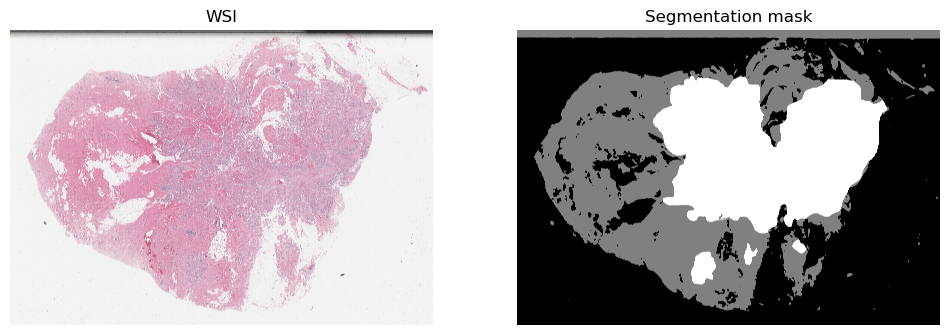

In [105]:
# Visually confirm that we are working with corresponding images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(slide10X); ax1.axis('off'); ax1.set_title("WSI")
ax2.imshow(mask, cmap="gray"); ax2.axis('off'); ax2.set_title("Segmentation mask")

In [120]:
PATCH_SIZE=5000
STRIDE=PATCH_SIZE

pil2tensor = transforms.ToTensor()

print(slide10X.size)
slide_tensor = pil2tensor(slide10X)
slide_tensor.shape

patches = slide_tensor.data.unfold(0, 3, 3).unfold(1, PATCH_SIZE, STRIDE).unfold(2, PATCH_SIZE, STRIDE)
print(patches.shape)

# patches = slide10X.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

# fig, ax = plt.subplots(4, 4)
# for i in range(4):
#     for j in range(4):
#         sub_img = patches[:, i, j]
#         ax[i][j].imshow(to_pil_image(sub_img))
#         ax[i][j].axis('off')

(33557, 23395)
torch.Size([1, 4, 6, 3, 5000, 5000])


## Testing my functions

In [14]:
import sys
sys.path.append('/Users/alexandrasmith/Desktop/Workspace/Projects/masters/src/')
from data.preprocessing import *

In [15]:
PATCH_SIZE=5000
STRIDE=PATCH_SIZE

In [19]:
print(slide10X.shape)

(23395, 33557, 3)


In [17]:
im_patches = image_to_patches(slide10X, PATCH_SIZE, STRIDE)

In [18]:
print(im_patches.shape)

torch.Size([24, 3, 5000, 5000])


In [23]:
first_patch = im_patches[0, :, :, :]
print(first_patch.shape)

i = 3
ith_patch = im_patches[i, :, :, :]

torch.Size([3, 5000, 5000])


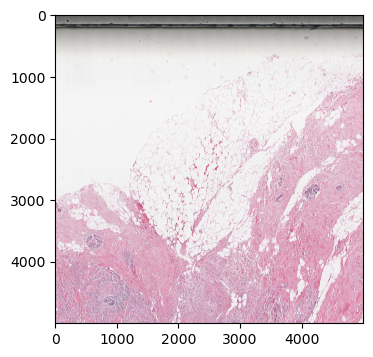

In [26]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(ith_patch.numpy(), (1, 2, 0)))

In [29]:
mask_patches = image_to_patches(mask, PATCH_SIZE, STRIDE)

print(mask_patches.shape)

torch.Size([24, 5000, 5000])


In [31]:
first_m_patch = mask_patches[0, :, :]
print(first_m_patch.shape)

i = 3
ith_m_patch = mask_patches[i, :, :]

torch.Size([5000, 5000])


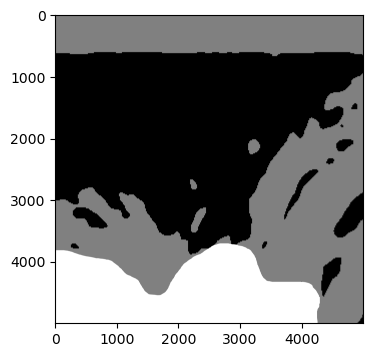

In [33]:
# View patch
plt.figure(figsize=(4, 4))
plt.imshow(ith_m_patch.numpy(), cmap="gray")
# plt.imshow(np.transpose(ith_m_patch.numpy(), (1, 2, 0)))